In [1]:
import cmdstanpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmdstanjupyter
import arviz
plt.style.use("ggplot")

In [2]:
%load_ext cmdstanjupyter

In [3]:
df = pd.read_parquet("../../customdataset/accum_curve_dataset.parquet")

In [4]:
df["date_idx"] = df["date"].dt.dayofyear

In [6]:
%%stan model4
data {
  int N_X;
  vector[N_X] y_price;           // 0..10 を想定
}
parameters {
  real<lower=0,upper=20> a;
  real<lower=0.8,upper=1.2> x0;  // n/1000 スケールに合わせた中心
  real<lower=1e-6> sigma_y;      // ★ 0 を避ける
  real<lower=0.2> delta;         // ★ 中腹幅の下限（要調整）
}
transformed parameters {
  real k = (2.0 * log(9)) / delta;
}
model {
  // 弱情報の事前（必要に応じて調整）
  a       ~ normal(10, 5);               // 上下限が 0..10 なら a≃10 付近
  delta   ~ normal(0.8, 0.3);            // 中腹幅の事前（n/1000スケール）
  sigma_y ~ normal(0, 0.5);              // half-normal(0.5)

  for (n in 1:N_X) {
    real x = n / 1000.0;
    real mu = a / (1 + exp(-k * (x - x0)));
    y_price[n] ~ normal(mu, sigma_y);
  }
}
generated quantities {
  vector[N_X] y_new;
  for (n in 1:N_X) {
    real x = n / 1000.0;
    real mu = a / (1 + exp(-k * (x - x0)));
    y_new[n] = normal_rng(mu, sigma_y);
  }
}

INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "model4"
INFO:cmdstanjupyter:StanModel now available as variable "model4"!
 Compilation took a moment.


In [7]:
df_sel = df.query("date=='2022-01-01'").query("hour==0")

/tmp/ipykernel_2036/2291006699.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_sel = df.query("date=='2022-01-01'").query("hour==0")


In [8]:
df_sel["x_scale"] = df_sel["x"] /1000

In [9]:
df_sel = df_sel.reset_index()

In [10]:
data = {
    "N_X":len(df_sel),
    "y_price":df_sel["y"].values
}

In [11]:
fit=model4.sample(data=data,seed=1234,iter_warmup=1000,iter_sampling=2000)

11:03:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:03:43 - cmdstanpy - INFO - CmdStan done processing.


In [12]:
fit.diagnose()

'Checking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nRank-normalized split effective sample size satisfactory for all parameters.\n\nRank-normalized split R-hat values satisfactory for all parameters.\n\nProcessing complete, no problems detected.\n'

In [18]:
df = fit.summary(percentiles=[5,25,50,75,95],)
y_new_list = [f"y_new[{i}]" for i in range(1,2001+1)]
df = df.loc[y_new_list,:]

In [19]:
df = df.reset_index(drop=True)

In [21]:
df["obs"] = df_sel["y"]

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>],
       [<Axes: title={'center': 'sigma_y'}>,
        <Axes: title={'center': 'sigma_y'}>]], dtype=object)

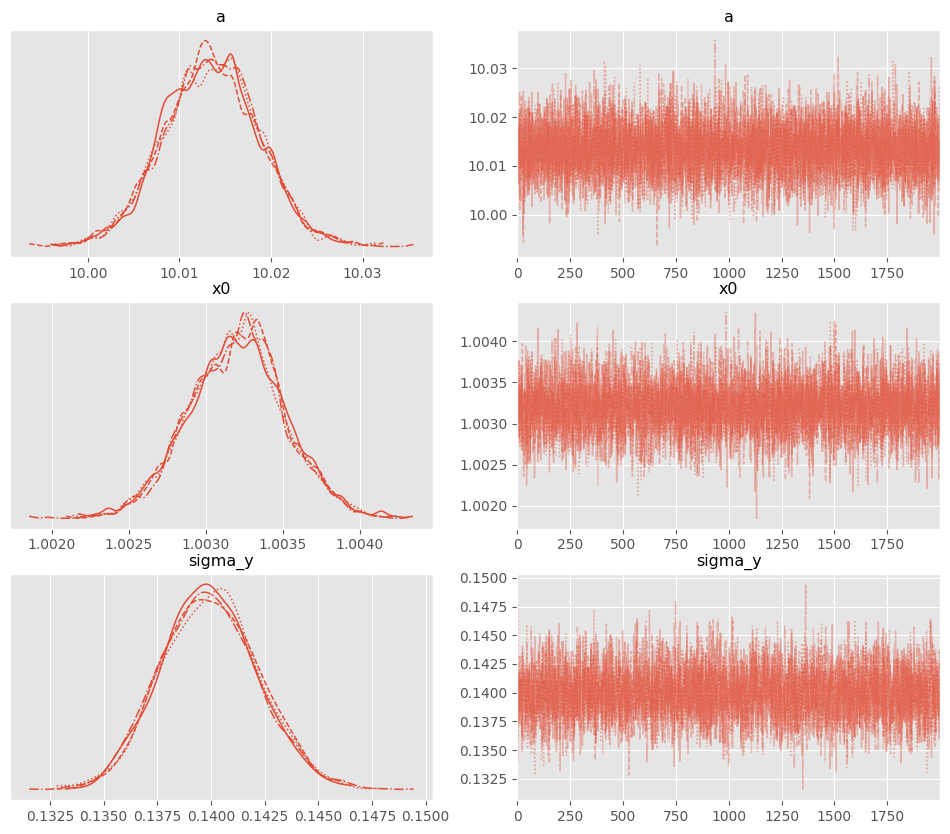

In [42]:
arviz.plot_trace(arviz.from_cmdstanpy(fit), var_names=["a","x0","sigma_y"], figsize=(12,10))

In [77]:
df.index = df_sel.index

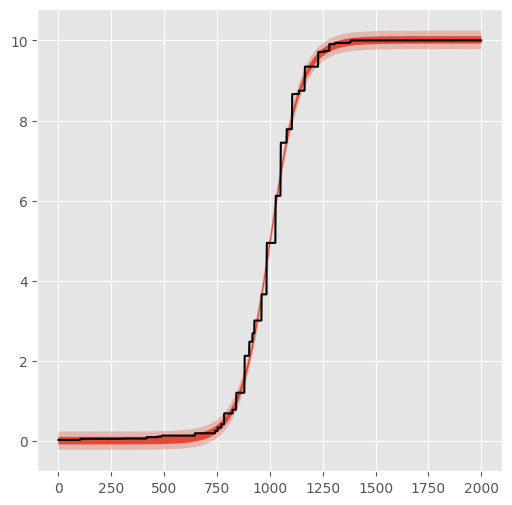

In [38]:
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(df.index,df["obs"], c="k")
ax.fill_between(df.index, df["5%"], df["95%"], facecolor="C0", alpha=0.3)
ax.fill_between(df.index, df["25%"], df["75%"], facecolor="C0", alpha=1)

In [29]:
fit=model.sample(data=data,seed=1234,iter_warmup=1000,iter_sampling=2000)

18:07:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:07:38 - cmdstanpy - INFO - CmdStan done processing.
18:07:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is -nan, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
Exception: normal_lpdf: Location parameter is -nan, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'model.stan', line 13, column 8 to column 61)
	Exception: normal_lpdf: L

18:07:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 334 divergent transitions (16.7%)
	Chain 2 had 3 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [30]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,1673.620000,237.674000,726.933000,1.356580,-923.213000,1854.570000,1855.99000,29.2939,4000.0000,1.09815
a,9.960090,0.069888,0.225501,0.006523,9.538670,10.012500,10.02250,48.0359,4000.0000,1.06990
k,0.106405,0.122903,0.413635,0.000066,0.013786,0.013886,0.13276,47.4958,4000.0000,1.07655
x0,401.087000,2.861060,10.120500,0.391406,397.434000,403.191000,403.80600,44.7122,4000.0000,1.05966
sigma_y,0.264571,0.135732,0.425900,0.003394,0.157087,0.162127,1.19281,27.4670,2396.3700,1.09669
...,...,...,...,...,...,...,...,...,...,...
y_new[1397],9.962070,0.056084,0.562953,0.170818,9.672400,10.008900,10.31220,5109.4100,26.8652,1.05974
y_new[1398],9.956640,0.065622,0.552809,0.173968,9.663660,10.006900,10.30530,728.7630,22.6453,1.05875
y_new[1399],9.967580,0.052622,0.537130,0.175985,9.657300,10.008500,10.31310,4093.3700,24.5980,1.06030
y_new[1400],9.953600,0.070701,0.550274,0.175414,9.646930,10.004900,10.30420,862.7750,22.9329,1.05694


array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'x0'}>]],
      dtype=object)

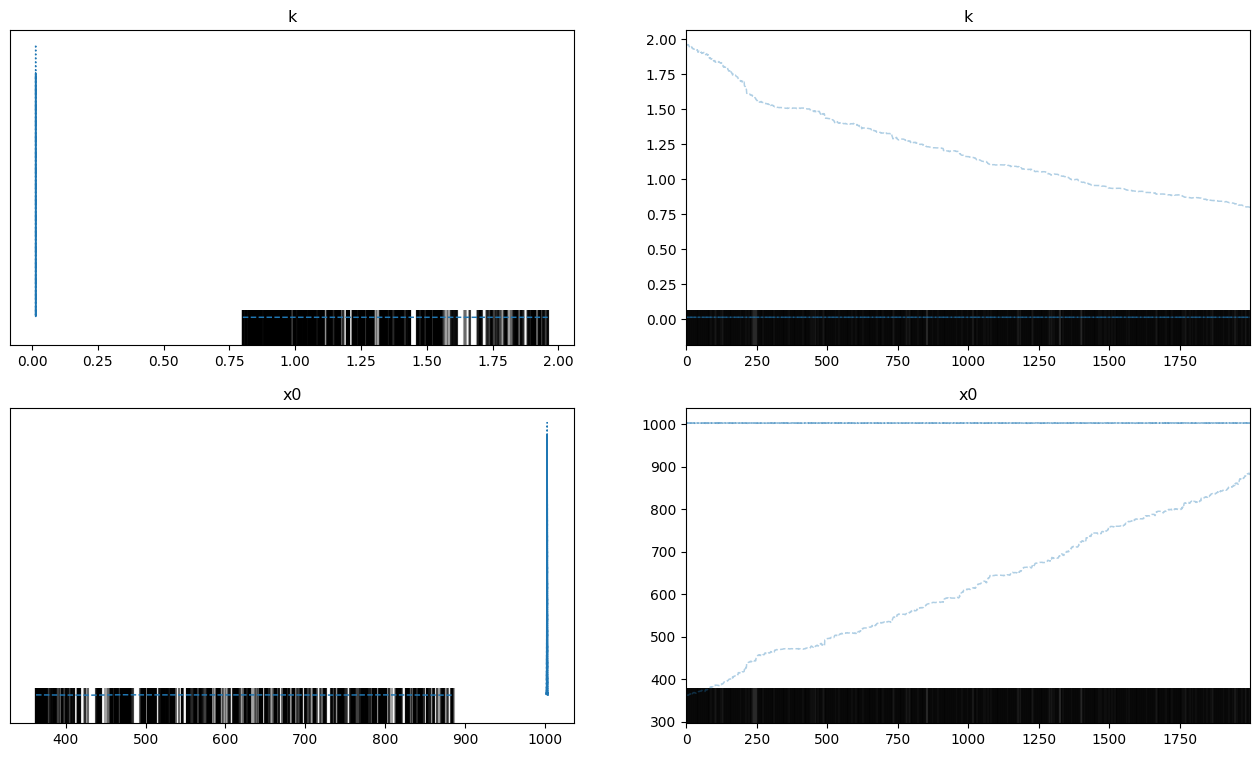

In [10]:
x=arviz.from_cmdstanpy(fit)
arviz.plot_trace(x,var_names=["k","x0"],figsize=(16,9))